## Goal
The objective of this project is to build one or more clustering models to determine similar movies to recommend using the other ratings and tags of movies by other users as features.

## Load and View the Dataset
I import the necessary libraries:

In [301]:
import pandas as pd #load the data into panda data frames
from sklearn.cluster import KMeans #KMeans clustering
import numpy as np #numpy
from sklearn import preprocessing #label encoder
from sklearn.cluster import MeanShift
import matplotlib.pyplot as plt

I initially picked the [100K Dataset](https://grouplens.org/datasets/movielens/100k/) and parsed it as tab separated values, but realized that it only had genre information and not tags. Instead, I chose a different dataset called [MovieLens Latest Datasets](https://grouplens.org/datasets/movielens/latest/) with csv files for tags, movies and ratings. To understand what data it contained, I referred to the data source's readme:
- movie ids are consistent between `ratings.csv`, `tags.csv`, `movies.csv`
- ratings are made on a 5-star scale, with half-star increments (0.5 stars - 5.0 stars)
- tags are user-generated metadata about movies. Each tag is typically a single word or short phrase

### ratings.csv

In [302]:
ratings = pd.read_csv('../data/raw/ml-latest-small/ratings.csv') 
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


### movies.csv

In [303]:
movies = pd.read_csv('../data/raw/ml-latest-small/movies.csv') 
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### tags.csv

In [304]:
tags = pd.read_csv('../data/raw/ml-latest-small/tags.csv') 
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


## Feature Engineering and Cleaning

### 1. Remove timestamp
I find the timestamp do not bring any value to the dataset, and so drop those columns.

In [305]:
tags = tags.drop(columns='timestamp')
ratings = ratings.drop(columns='timestamp')

### 2. Add a Column For Average Ratings
I merge the average ratings of the movie into the movies data frame. I perform this by:
- creating a unique movie ids list
- adding all the ratings together using a map
- divide by the number of ratings for each movie to obtain the mean

In [306]:
ids = list(ratings['movieId'])
unique_ids = list(set(ids))


id_rating_pair = dict.fromkeys(unique_ids)
counts = {}

# track sum and count for each movieid
for index, row in ratings.iterrows():
    if id_rating_pair[row['movieId']] == None:
        counts[row['movieId']] = 1
        id_rating_pair[row['movieId']] = row['rating']
    else:
        id_rating_pair[row['movieId']] = id_rating_pair[row['movieId']] + row['rating']
        counts[row['movieId']] = counts[row['movieId']] + 1
 
# compute means
for key, value in id_rating_pair.items(): 
    id_rating_pair[key] = round(id_rating_pair[key]/counts[key], 2)

# add column to the movies data frame
movies['ratings']= movies['movieId'].map(id_rating_pair)

In [307]:
movies.head()

,movieId,title,genres,ratings
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.92
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.43
2,3,Grumpier Old Men (1995),Comedy|Romance,3.26
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.36
4,5,Father of the Bride Part II (1995),Comedy,3.07


### 3. Create tags list for each movie
I create a column tags and assign each movie all the tags that users have assigned to it. I do this by:
- adding all the tags to a list using a map
- divide by the number of ratings for each movie to obtain the mean
- ensure duplicates are not added

In [308]:
id_tag_pair = dict.fromkeys(unique_ids)

# merge tags and movies df on movieid by creating a list of tags each movie is assigned
for index, row in tags.iterrows():
    if row['movieId'] in id_tag_pair:
        if id_tag_pair[row['movieId']] == None:
            id_tag_pair[row['movieId']] = [row['tag']]
        else:
            if row['tag'] not in id_tag_pair[row['movieId']]:
                id_tag_pair[row['movieId']] = id_tag_pair[row['movieId']] + [row['tag']]

# add tags column to the movies data frame
movies['tags']= movies['movieId'].map(id_tag_pair)
movies.head()

,movieId,title,genres,ratings,tags
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.92,"[pixar, fun]"
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.43,"[fantasy, magic board game, Robin Williams, game]"
2,3,Grumpier Old Men (1995),Comedy|Romance,3.26,"[moldy, old]"
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.36,None
4,5,Father of the Bride Part II (1995),Comedy,3.07,"[pregnancy, remake]"


### 4. Drop NaN values

In [309]:
tags = tags.dropna()
ratings = ratings.dropna()
movies = movies.drop(columns=['genres'])
movies = movies.dropna()

## Clustering Models

The clustering model I choose is MeanShift, which identifies dense areas of similar ratings. It adjusts the mean of the cluster to accomodates many datapoints. Here, I fit the model with the ratings from the movies dataframe and predict using certain a user's past rating behaviors. I take the rating history (sample_user_ratings) and create a prediction of movies with similar ratings.

In [310]:
X_ratings = movies[['ratings']].dropna()
X_ratings_list = X_ratings.values.tolist()
clustering = MeanShift().fit(X_ratings_list)

sample_user_ratings = [[4.8], [4.6], [4.7], [2.0], [4.3], [4.6], [1.2], [3.0]]
prediction = clustering.predict(sample_user_ratings)
prediction

array([1, 1, 1, 2, 0, 1, 2, 0])

I notice that `values<=2.0`, `3.0<=values<=4.3` and `values>=4.6` form three different clusters 0, 1 and 2. I plot these against the training data to understand the distribution.

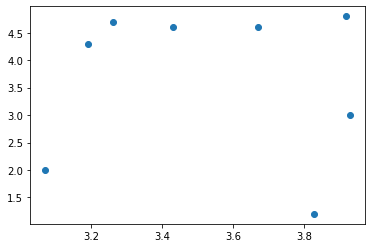

In [311]:
plt.scatter(np.array(X_ratings).tolist()[:8], sample_user_ratings)
plt.show()

#### Recommendations
Based on the scatter plot, the model has recommended movies with a rating greater than 4.5 as the points are closest together. For a user with past rating history like sample_user_ratings, the following would be good recommendations.

In [313]:
recommended = movies[movies['ratings'] > 4.5]
recommended

,movieId,title,ratings,tags
557,670,"World of Apu, The (Apur Sansar) (1959)",4.75,[India]
796,1041,Secrets & Lies (1996),4.59,[In Netflix queue]
883,1178,Paths of Glory (1957),4.54,"[court, military]"
2582,3451,Guess Who's Coming to Dinner (1967),4.55,"[Hepburn and Tracy, interracial marriage, prej..."
2947,3951,Two Family House (2000),5.00,[In Netflix queue]
3294,4454,More (1998),5.00,"[claymation, creativity, dystopia, free to dow..."
3320,4495,Crossing Delancey (1988),5.00,[New York]
3691,5088,"Going Places (Valseuses, Les) (1974)",5.00,[irreverent]
4251,6201,Lady Jane (1986),5.00,[England]
4284,6254,"Awful Truth, The (1937)",4.75,[screwball]
